# Introduction
This notebook is in continuation of previous notebook of NLP tutorial. As I told previously in my notebook that I will be covering almost all the practical approaches for NLP tasks, so here I will talk about few methods which were left.<br>

**In this kernel, I will be focusing on Word2Vec and Glove and will apply it to the same spam message classifier task.**<br>

But if you are a beginner to NLP or want to know some different approaches for NLP problems, I would refer you read my previous notebook first and then read this kernel:-
<div class="row" align="center">
    <div class = "card">
      <div class = "card-body" style = "width: 20rem; ">
        <h5 class = "card-title" style = "font-size: 1.2em;"align="center">A complete NLP notebook (spam message classifier)</h5>
          <img src="https://getthematic.com/insights/content/images/wordpress/2018/03/Neuro-linguistic-Programming-650x435-e1522404756134.jpg" class = "card_img-top" style = "padding: 2% 0;width:19rem;height:10rem;"  alt="...">
        <a href = "https://github.com/Printutcarsh/Complete-NLP-notebook--spam-message-classifier" class = "btn btn-info btn-lg active"  role = "button" style = "color: white; margin: 0 25% 0 25%" data-toggle = "popover" title = "Click">Click here</a>
      </div>
    </div>
  </div>

# Table of Contents
* Word Embeddings
* Importing Libraries
* Reading the data
* Data Pre-Processing
* Word2Vec
* Glove
* Summary

# Word Embeddings
* A word embedding is a learned representation for text where words that have the same meaning have a similar representation.<br>
* It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems.<br>
* Here I will talk about 2 word embedding techniques and that are Word2Vec and Glove.<br>
* Word2Vec learns embeddings by relating target words to their context. However, it ignores whether some context words appear more often than others. For Word2Vec, a frequent co-occurrence of words creates more training examples, but it carries no additional information.<br>
* In contrast, GloVe stresses that the frequency of co-occurrences is vital information and should not be “wasted ”as additional training examples. Instead, GloVe builds word embeddings in a way that a combination of word vectors relates directly to the probability of these words’ co-occurrence in the corpus.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, SimpleRNN, Bidirectional
from keras.optimizers import Adam

# Reading the data

In [2]:
df = pd.read_csv('spam-text-message-classification/SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Data Pre-Processing

For EDA of this dataset [click here](https://github.com/Printutcarsh/Complete-NLP-notebook--spam-message-classifier)

### Data Cleaning

In [4]:
def clean(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    return text

In [5]:
df['Message'] = df['Message'].apply(lambda x : clean(x))

In [6]:
def remove(text):
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [7]:
df['Message'] = df['Message'].apply(lambda x : remove(x))

In [8]:
y = pd.get_dummies(df['Category'])
y=y.iloc[:,1].values

In [9]:
X = df['Message'].values

### Tranform text to vectors

In [10]:
tokenizer_obj = Tokenizer(7641)
tokenizer_obj.fit_on_texts(X)
sequences = tokenizer_obj.texts_to_sequences(X)

In [11]:
word_index = tokenizer_obj.word_index

In [12]:
print("unique tokens -", len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1 #+1 for unknown word
print('vocab_size -', vocab_size)

unique tokens - 7641
vocab_size - 7642


### Padding

In [13]:
max_len = len(X.max())
lines_pad = pad_sequences(sequences, maxlen = max_len, padding='post')

### Splitting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(lines_pad, y, test_size = 0.20, random_state=3) 

# Word2Vec
Now, we will talk about the main topics. As you know, whenever we create our model for NLP task, we first create a embedding layer and we train that embedding layer also. But here we will use pre-trained embedding layer and will see how it performs. So first, lets see about pre-trained Word2Vec.

In [15]:
wordembeddings = gensim.models.KeyedVectors.load_word2vec_format('googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin', binary = True)

After importing the pre-trained model, we will create our embedding matrix and for that we will first initialize our matrix with zeros. Then, we will match our 

In [16]:
embedding_dim = 300
c=0
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    try:
        embedding_vector = wordembeddings[word]
    except:
        pass
    if embedding_vector is not None:
        c=c+1
        embedding_matrix[i] = embedding_vector     
print(c)

7641


Next, we will use that matrix and create our embedding layer and we will set trainable=False as we don't have to train this layer. 

In [17]:
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length = max_len,
                            trainable=False)

Now, here I will be using Bidirectional LSTM model as we saw previously that this was giving the best result and we will use this embedding layer that we have created.

In [18]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 77, 300)           2292600   
_________________________________________________________________
dropout (Dropout)            (None, 77, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 77, 200)           320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 77, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 77, 200)           240800    
_________________________________________________________________
dense (Dense)                (None, 77, 1024)          205824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 77, 1024)          0

Here you can also oberve that there are non-trainable parameters also.

In [20]:
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['acc'])

In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
140/140 [==============================] - 5s 38ms/step - loss: 0.1965 - acc: 0.9432 - val_loss: 0.1875 - val_acc: 0.9296
Epoch 2/10
140/140 [==============================] - 4s 27ms/step - loss: 0.1017 - acc: 0.9731 - val_loss: 0.0925 - val_acc: 0.9713
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0868 - acc: 0.9775 - val_loss: 0.0924 - val_acc: 0.9757
Epoch 4/10
140/140 [==============================] - 4s 28ms/step - loss: 0.1004 - acc: 0.9745 - val_loss: 0.0800 - val_acc: 0.9750
Epoch 5/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0649 - acc: 0.9829 - val_loss: 0.0890 - val_acc: 0.9703
Epoch 6/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0669 - acc: 0.9818 - val_loss: 0.0689 - val_acc: 0.9847
Epoch 7/10
140/140 [==============================] - 5s 35ms/step - loss: 0.0837 - acc: 0.9843 - val_loss: 0.0861 - val_acc: 0.9822
Epoch 8/10
140/140 [==============================] - 4s 28ms/step - 

# Train Word2Vec
Although pre-trained Word2Vec gives a very good result, but one of the problem is that you have to download a huge file and then you can run this. Instead of this, we can create our own Word2Vec embedding layer and we can do so by importing Word2Vec from gensim.models.

First, we will create a list of the words which are present in the dataset. Then we will apply Word2Vec on that list.

In [22]:
mes = []
for i in df['Message']:
    mes.append(i.split())
word_2_vec = Word2Vec(mes, size=100, window=3, min_count=1, workers=16)

Afterthat, we will again use the same model but here to get embedding layer we use a different method and here we will train this embedding layer also.

In [23]:
model2 = Sequential()
model2.add(word_2_vec.wv.get_keras_embedding(True))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(100, return_sequences = True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(100, return_sequences = True)))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         764100    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 200)         240800    
_________________________________________________________________
dense_3 (Dense)              (None, None, 1024)        205824    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 1024)       

In [25]:
model2.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['acc'])

In [26]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
140/140 [==============================] - 7s 47ms/step - loss: 0.3871 - acc: 0.8694 - val_loss: 0.2567 - val_acc: 0.9233
Epoch 2/10
140/140 [==============================] - 5s 33ms/step - loss: 0.1370 - acc: 0.9763 - val_loss: 0.1600 - val_acc: 0.9601
Epoch 3/10
140/140 [==============================] - 5s 35ms/step - loss: 0.1499 - acc: 0.9639 - val_loss: 0.1187 - val_acc: 0.9743
Epoch 4/10
140/140 [==============================] - 5s 33ms/step - loss: 0.0746 - acc: 0.9877 - val_loss: 0.0931 - val_acc: 0.9799
Epoch 5/10
140/140 [==============================] - 5s 36ms/step - loss: 0.0562 - acc: 0.9898 - val_loss: 0.0699 - val_acc: 0.9850
Epoch 6/10
140/140 [==============================] - 5s 36ms/step - loss: 0.0254 - acc: 0.9960 - val_loss: 0.0896 - val_acc: 0.9883
Epoch 7/10
140/140 [==============================] - 5s 39ms/step - loss: 0.0515 - acc: 0.9914 - val_loss: 0.1344 - val_acc: 0.9693
Epoch 8/10
140/140 [==============================] - 5s 35ms/step - 

Let us compare the performance of both the models.

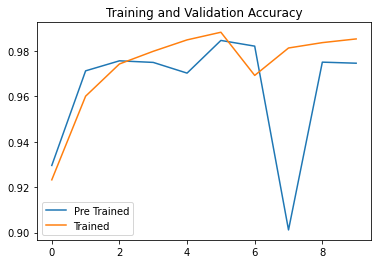

In [27]:
metrics1 = pd.DataFrame(model.history.history)
metrics2 = pd.DataFrame(model2.history.history)
metrics1['val_acc'].plot(label='Pre Trained')
metrics2['val_acc'].plot(label='Trained')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Glove
And now we will see how to use pre-trained Glove.<br>
First, we will read our Glove file and will create a dictionary using it. The dictionary will contain words as keys and its vector representation as values.

In [28]:
embedding_index={}
embedding_dim = 100
with open('glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
    f.close()

print('Found %s word vectors' % len(embedding_index))

Found 400000 word vectors


Now again we have to build our Embedding layer and for that we first create our embedding matrix in a similar way we previously did.

In [29]:
embedding_matrix2 = np.zeros((vocab_size, embedding_dim))
c= 0
for word, i in word_index.items():
    embedding_vector2 = embedding_index.get(word)
    if embedding_vector2 is not None:
        c=c+1
        embedding_matrix2[i] = embedding_vector2
print(c)

6281


Then we create our embedding layer.

In [30]:
embedding_layer2 = Embedding(vocab_size, 
                            embedding_dim, 
                            weights=[embedding_matrix2], 
                            input_length = max_len, 
                            trainable=False)

Again we will use that same model and here we will use our new embedding layer.

In [31]:
model3 = Sequential()
model3.add(embedding_layer2)
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100, return_sequences = True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100, return_sequences = True)))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

In [32]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 77, 100)           764200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 77, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 77, 200)           160800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 77, 200)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 77, 200)           240800    
_________________________________________________________________
dense_6 (Dense)              (None, 77, 1024)          205824    
_________________________________________________________________
dropout_10 (Dropout)         (None, 77, 1024)         

In [33]:
model3.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['acc'])

In [34]:
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
140/140 [==============================] - 5s 38ms/step - loss: 0.2163 - acc: 0.9301 - val_loss: 0.1154 - val_acc: 0.9617
Epoch 2/10
140/140 [==============================] - 4s 30ms/step - loss: 0.1248 - acc: 0.9698 - val_loss: 0.1553 - val_acc: 0.9633
Epoch 3/10
140/140 [==============================] - 4s 26ms/step - loss: 0.1252 - acc: 0.9663 - val_loss: 0.1999 - val_acc: 0.9490
Epoch 4/10
140/140 [==============================] - 4s 26ms/step - loss: 0.1476 - acc: 0.9566 - val_loss: 0.1508 - val_acc: 0.9605
Epoch 5/10
140/140 [==============================] - 4s 27ms/step - loss: 0.1653 - acc: 0.9515 - val_loss: 0.1181 - val_acc: 0.9583
Epoch 6/10
140/140 [==============================] - 4s 28ms/step - loss: 0.2025 - acc: 0.9462 - val_loss: 0.3202 - val_acc: 0.9000
Epoch 7/10
140/140 [==============================] - 4s 26ms/step - loss: 0.1565 - acc: 0.9518 - val_loss: 0.1409 - val_acc: 0.9595
Epoch 8/10
140/140 [==============================] - 4s 28ms/step - 

In [35]:
metrics3 = pd.DataFrame(model3.history.history)

Let us compare both the pre-trained models.

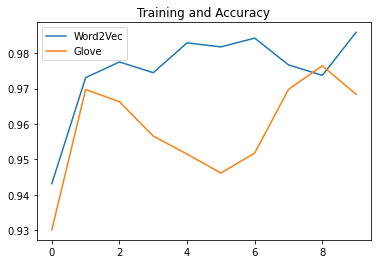

In [36]:
metrics1['acc'].plot(label='Word2Vec')
metrics3['acc'].plot(label='Glove')
plt.title("Training and Accuracy")
plt.legend()
plt.show()

Here we can observe some difference because our Word2Vec model has embedding layer with 300 dimensions whereas our Glove model has embedding layer with 100 dimensions. That is why Word2Vec model is performing better than Glove model.

# Summary

This was all about Word2Vec and Glove. These are very useful for NLP tasks and it works very well for a very large dataset.<br>
I hope now you will also be able to apply this techniques in your dataset.<br>
Again, I would like to tell if you want to know some more different approaches for NLP problems, you can refer my another notebook:- [click here](https://github.com/Printutcarsh/Complete-NLP-notebook--spam-message-classifier)

<h1 align='center'> THANK YOU VERY MUCH FOR READING!</h1>